# Data EDA

**!! In order to benefit from the geographical EDA and see properly the maps click [here](https://nbviewer.jupyter.org/github/imrane-boucher/eda_restaurant_paris/blob/master/data_eda.ipynb).**

### Librairies

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
import qgrid
import json

In [3]:
# if I ever want to visualize the whole output:
#pd.options.display.max_rows = 4000

### import data

In [4]:
df = pd.read_csv('data/restaurant_cleaned.csv')

In [5]:
df.head(100)

,name,review_count,categories,rating,price,zip_code,street
0,Baroche,204,brasseries,4.0,2.0,75008.0,rue la Boétie
1,Le Train Bleu,256,french,4.0,4.0,75012.0,Place Louis Armand
2,La Méthode,29,french,4.0,2.0,75005.0,rue Descartes
3,Little Breizh,206,creperies,4.5,2.0,75006.0,rue Grégoire de Tours
4,La Consigne,7,brasseries,4.0,2.0,75012.0,rue de Lyon
...,...,...,...,...,...,...,...
95,La Petite Périgourdine,114,french,4.0,3.0,75005.0,rue des Ecoles
96,Kanna Tanna,7,srilankan,5.0,NaN,75009.0,rue Jean Baptiste Pigalle
97,Chouette,4,french,5.0,2.0,75020.0,rue des Pyrénées
98,Gemini,32,italian,4.5,2.0,75001.0,rue des Halles


### I. Data preparation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          950 non-null    object 
 1   review_count  950 non-null    int64  
 2   categories    950 non-null    object 
 3   rating        950 non-null    float64
 4   price         750 non-null    float64
 5   zip_code      949 non-null    float64
 6   street        947 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 52.1+ KB


#### a. Deal with the null values

In [7]:
# a few new values for zip_code and street so we can just drop the corresponding rows
df  = df[~df['street'].isnull() & ~df['zip_code'].isnull()]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946 entries, 0 to 949
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          946 non-null    object 
 1   review_count  946 non-null    int64  
 2   categories    946 non-null    object 
 3   rating        946 non-null    float64
 4   price         747 non-null    float64
 5   zip_code      946 non-null    float64
 6   street        946 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 59.1+ KB


In [9]:
# for prices we are going to try to fill missing prices by the average price of restaurants belonging to the same category and located in the same area
df.groupby(['zip_code', 'categories']).mean()['price']

zip_code  categories
75001.0   african            NaN
          bakeries      2.000000
          bbq           3.000000
          bistros       2.000000
          brasseries    2.111111
                          ...   
75116.0   cafes              NaN
          fishnchips         NaN
          french        3.000000
          moroccan      2.000000
94140.0   armenian           NaN
Name: price, Length: 339, dtype: float64

In [10]:
df["price"] = df.groupby(['zip_code', 'categories'])['price'].transform(lambda x: x.fillna(x.mean()))

In [11]:
# for the nan price remaining we are just going to drop the corresponding rows
df = df[~df['price'].isnull()]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877 entries, 0 to 948
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          877 non-null    object 
 1   review_count  877 non-null    int64  
 2   categories    877 non-null    object 
 3   rating        877 non-null    float64
 4   price         877 non-null    float64
 5   zip_code      877 non-null    float64
 6   street        877 non-null    object 
dtypes: float64(3), int64(1), object(3)
memory usage: 54.8+ KB


In [13]:
# round price data so it can be treated as a categorical feature
df['price'] = df.loc[:, 'price'].apply(lambda x: round(x, 0))

In [14]:
df.price.value_counts()

2.0    464
3.0    313
4.0     55
1.0     45
Name: price, dtype: int64

In [15]:
# convert zip_code to integer 
df['zip_code'] = df['zip_code'].apply(lambda x: int(x))


### II. Stastical EDA

In [16]:
sns.set(color_codes=True, palette='coolwarm_r', style='darkgrid')

In [17]:
df.columns

Index(['name', 'review_count', 'categories', 'rating', 'price', 'zip_code',
       'street'],
      dtype='object')

In [18]:
df.describe()

,review_count,rating,price,zip_code
count,877.000000,877.000000,877.000000,877.000000
mean,54.506271,4.305587,2.431015,75010.865450
std,77.574866,0.418061,0.688354,16.615176
min,1.000000,1.500000,1.000000,75001.000000
25%,9.000000,4.000000,2.000000,75004.000000
50%,26.000000,4.500000,2.000000,75008.000000
75%,67.000000,4.500000,3.000000,75014.000000
max,945.000000,5.000000,4.000000,75116.000000


In [19]:
# categorize the variables between the numerical, the categorical and the categorial with many classes 
var_num = [df['review_count']]
var_cat = [df['rating'], df['price'], df['zip_code']]
var_cat_lg = [df['categories'], df['street']]

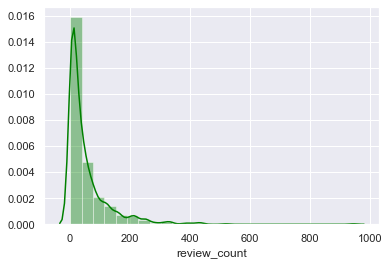

In [20]:
for var in var_num:
    sns.distplot(var, bins= 25, color='g')
    plt.show()

In [21]:
# review_count is skewed

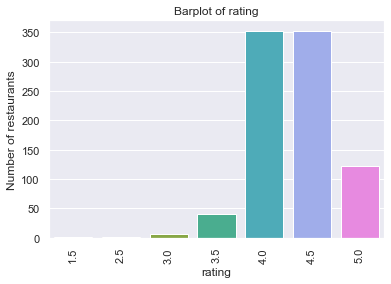

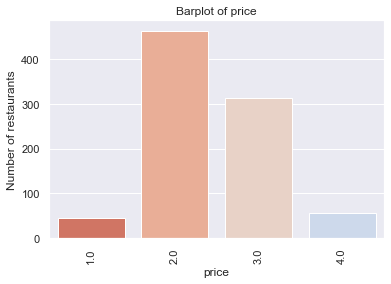

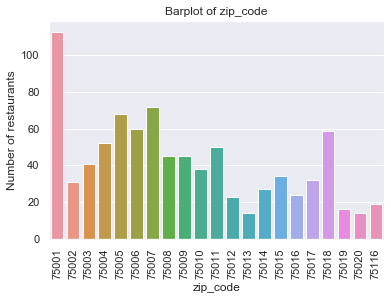

In [22]:
for var in var_cat:
    sns.barplot(x = var.value_counts().index, y=var.value_counts().values)
    plt.xlabel(var.name)
    plt.ylabel('Number of restaurants')
    plt.xticks(rotation='vertical')
    plt.title('Barplot of ' + var.name)
    plt.show()

**Analysis**: The global ranking of restaurants in Paris seem pretty good. It is something we were quite expecting since France is a country known for the quality of its cuisine

**Analysis**: They seem to be far more restaurants in the 1st arrondissement compared to the others. This result seems pretty suprising and should be interpreted with caution. In fact we are only analysing a sample (877) of the total number of restaurants in Paris, and the sample selection process might have randomely  favored restaurants located in the 1st arrondissement

In [23]:
# there's a double value "rue Saaint-Honoré" & "rue Saint Honoré"
# we can rectify it by replacing all "-" by a regular space
# + make sure street data is easily accessible
df['street'] = df['street'].str.replace('-', ' ')
df['street'] = df['street'].str.strip()
df['street'] = df['street'].astype(str)

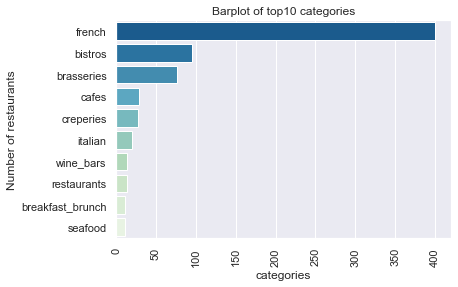

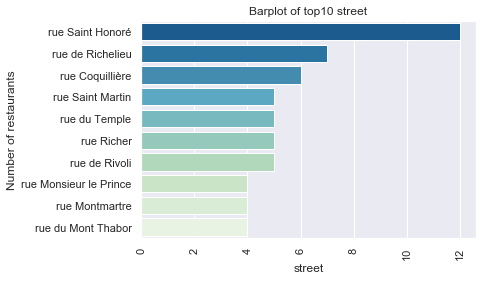

In [24]:
for var in var_cat_lg:
    sns.barplot(y = var.value_counts().index[:10], 
                x=var.value_counts().values[:10],
                palette='GnBu_r')
    plt.xlabel(var.name)
    plt.ylabel('Number of restaurants')
    plt.xticks(rotation='vertical')
    plt.title('Barplot of top10 ' + var.name)
    plt.show()

**Analysis**: The fact that these street hosts the highest number of restaurants can be explained by their length (specially "rue Saint Honoré") & can approxamitely quantify how busy the street is

In [25]:
# QUESTION: among the top 5 streets in number of restaurants which street is the one
# with the biggest rating average / average price / number of reviews

In [26]:
busy_streets = df['street'].value_counts().index[:5].str.strip()
busy_streets

Index(['rue Saint Honoré', 'rue de Richelieu', 'rue Coquillière',
       'rue Saint Martin', 'rue du Temple'],
      dtype='object')

In [27]:
avg_prices = []
avg_ratings = []

for st in busy_streets:
    # for each busy street (top 5 streets with the biggest amount of restaurants) get the average price of the restaurants
    price = df[df['street'] == st]['price'].mean()
    avg_prices.append(price)
    # the average rating of the restaurants 
    rating = df[df['street'] == st]['rating'].mean()
    avg_ratings.append(rating)
    

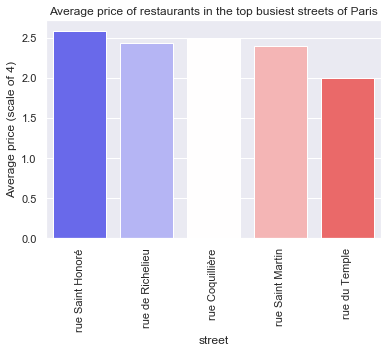

In [28]:
sns.barplot(x=busy_streets, y=avg_prices, palette='bwr')
plt.xlabel(('street'))
plt.ylabel('Average price (scale of 4)')
plt.xticks(rotation='vertical')
plt.title('Average price of restaurants in the top busiest streets of Paris')
plt.show()

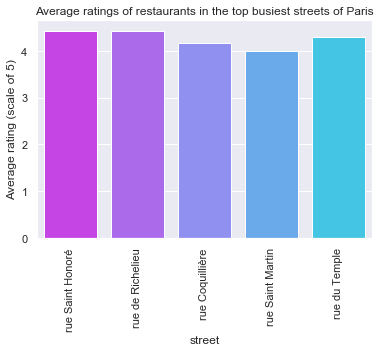

In [29]:
sns.barplot(x=busy_streets, y=avg_ratings, palette='cool_r')
plt.xlabel(('street'))
plt.ylabel('Average rating (scale of 5)')
plt.xticks(rotation='vertical')
plt.title('Average ratings of restaurants in the top busiest streets of Paris', )
plt.show()

**Analysis**:  'Rue du Temple' seems to have relatively good rating restaurants for a relatively low price in comparisson to the other four 'busy streets'

### II. Geographical EDA

In [30]:
# build dataframe for the geographical analysis by 'arrondissement'
df_folium = df.groupby(by=['zip_code']).mean()
df_folium['num_restaurants'] = df['zip_code'].value_counts()
df_folium['zip_code'] = df_folium.index

In [31]:
# convert zip_codes into string object so it matches the codes in the geojson file
df_folium['zip_code'] = df_folium['zip_code'].astype(str)


In [32]:
# create a dataframe for normalized values 
df_norm = df_folium.copy()
df_norm = df_norm.drop(['zip_code'], axis=1)
df_norm = (df_norm - df_norm.min()) / (df_norm.max() - df_norm.min())
df_norm['zip_code'] = df_norm.index
df_norm['zip_code'] = df_norm['zip_code'].astype(str)

In [33]:
zip_geo = 'data/paris.geojson'


In [34]:
# map of arrondissement in Paris based on the number of restaurants
m = folium.Map(location=[48.8567, 2.3508], zoom_start=12)

folium.Choropleth(
    geo_data=zip_geo,
    data=df_norm,
    columns=['zip_code', 'num_restaurants'],
    key_on='feature.properties.code',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of restaurants').add_to(m)

folium.LayerControl().add_to(m)

m.save('./maps/number_of_restaurants.html')

m



In [35]:
# map of arrondissement in Paris based on the average rating of the restaurants
m = folium.Map(location=[48.8567, 2.3508], zoom_start=12)

folium.Choropleth(
    geo_data=zip_geo,
    data=df_norm,
    columns=['zip_code', 'rating'],
    key_on='feature.properties.code',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average ratings of restaurants').add_to(m)

folium.LayerControl().add_to(m)

m.save('./maps/restaurants_avg_rating.html')
m



In [36]:
# map of arrondissement in Paris based on the average price of the restaurants
m = folium.Map(location=[48.8567, 2.3508], zoom_start=12)

folium.Choropleth(
    geo_data=zip_geo,
    data=df_norm,
    columns=['zip_code', 'price'],
    key_on='feature.properties.code',
    fill_color='GnBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average price of restaurants').add_to(m)

folium.LayerControl().add_to(m)

m.save('./maps/restaurants_avg_price.html')
m


**Analysis**: By now I know where area to avoid in Paris to look for a restaurant. The far west of paris has on average the most expensives restaurants and the far east seems to have fewer restaurants than in the center. Concerning the 8th arrondissement (Champs Elysées etc.), it seems to be a very bad place for looking for a restaurant since the average price is comparatively high while the average rating is pretty low) 
But where should I go ? Let's look for the area where we can find the restaurants with **the best value for money**. 

In [37]:
# calculate a quality-price ratio average for each arrondissement
df_folium['quality_price'] = df_folium['rating'] / df_folium['price']
# let's normalise 'quality_price' so we only get values between 0 and 1
df_folium['quality_price'] = (df_folium['quality_price'] - df_folium['quality_price'].min()) / (df_folium['quality_price'].max()
- df_folium['quality_price'].min())


#### Map of arrondissement in Paris based on the average quality price ratio of the restaurants

In [38]:
# map of arrondissement in Paris based on the average quality price ratio of the restaurants
m = folium.Map(location=[48.8567, 2.3508], zoom_start=12)

folium.Choropleth(
    geo_data=zip_geo,
    data=df_folium,
    columns=['zip_code', 'quality_price'],
    key_on='feature.properties.code',
    fill_color='RdYlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average quality price ratio').add_to(m)

folium.LayerControl().add_to(m)

m.save('./maps/restaurants_avg_quality_price.html')
m


**Analysis**: The west part of Paris as well as the 8th arrondissement definitely seems a bad choice to pick a restaurant since they give the worse value for money. If the far east seems to present an attractive quality price ratio, I will avoid this area since it is pretty far from the center. **My recommandation based on this analysis would therefore be to look for a restaurant in the 3rd Arrondissement or in the 5th since they have an attractive location while still hosting good value for money restaurants**